# Imports and previous functions 

In [44]:
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy import API
from tweepy import Cursor
import json
import datetime
import pandas as pd
import collections
from collections import Counter
from collections import defaultdict
import csv
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as la
import time
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from array import array
import math
import operator
import itertools

In [85]:
df_tweets = pd.read_json('file.json', orient ='split', compression = 'infer') 

In [86]:
df_tweets = df_tweets.fillna(value=np.nan)

In [87]:
def getrts(df_tweets):
    retweets_ = df_tweets["retweeted_status"].apply(lambda x:0 if str(x)=='nan' else 1)
    return retweets_

In [88]:
#We recieve a list of 0 if tweet is unique and 1 if it is a retweet
retweets = getrts(df_tweets)
#We get the index of the retweets
retweets = retweets[retweets == 1]
retweets = retweets.index.values
#We now get df_unique which are the original tweets and df_retweeted which are the retweeted tweets
df_unique = df_tweets.drop(retweets,axis=0)
df_unique = df_unique.reset_index(drop=True)
df_retweeted = df_tweets.loc[retweets]
df_retweeted = df_retweeted[df_retweeted['retweeted_status'].notna()]
df_retweeted = df_retweeted.reset_index(drop=True)

In [92]:
#We get common columns between the retweeted and the original tweets 
cols = df_retweeted.columns&df_retweeted.at[0,'retweeted_status'].keys()

for i in range(0,len(df_retweeted)):
    for col in cols:
        if col in df_retweeted.at[i,'retweeted_status'].keys():
            #Substitute the columns of the retweeted tweet by the original one
            if col != 'possibly_sensitive':
                df_retweeted.at[i,col] = df_retweeted.at[i,'retweeted_status'][col] 

In [93]:
df_tweets = pd.concat([df_unique, df_retweeted], ignore_index=True)
df_tweets = df_tweets.drop_duplicates(subset=['id'])
df_tweets = df_tweets.reset_index(drop=True)

In [94]:
lines = [None]*len(df_tweets)
for i in range(0,len(df_tweets)):
    
    if type(df_tweets.at[i,'extended_tweet']) != float:
        lines[i] = df_tweets.at[i,'extended_tweet']['full_text']
    
    else:
        lines[i] = df_tweets.at[i,'text']

lines = [l.strip() for l in lines]

In [95]:
def remove_mentions(text):
    
    result = text.split()
    aux = text.split()
    for word in aux:
        if '@' in word:
            result.remove(word)
        elif 'https' in word:
            result.remove(word)
    result = ' '.join(result)
    
    return deEmojify(result)

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def delete_hashtags(text):
    
    result = text.split()
    aux = text.split()
    for word in aux:
        if '#' in word:
            result.remove(word)
    result = ' '.join(result)
    
    return result

def getTerms(line):
    
    #We remove mentions (@username) and links
    line = remove_mentions(line)
    #We remove Hashtags
    line = delete_hashtags(line)
    #We will get rid of RTs
    line= line.replace("RT ", "").strip()
    #We remove punctuations
    line=  line.lower() 
    line = re.sub(r'[^\w\s]','',line).strip()
    #We remove stop-words
    line=  line.split()
    stops = set(stopwords.words("english"))
    line=[word for word in line if word not in stops] 
    #Stemming
    stemming = PorterStemmer()
    line=[stemming.stem(word) for word in line] 
    
    return line

def create_index_tfidf(lines, numDocuments):
        
    index=defaultdict(list)
    
    #Term frequencies of terms in documents (tweets)
    tf=defaultdict(list) 
    
    #Document (tweet) frequencies of terms in the corpus
    df=defaultdict(int)         
    
    #Inverse document (tweet) frequencies
    idf=defaultdict(float)
    
    #Count we will use to assign IDs to tweets
    count = 0
    
    for line in lines:
        
        tweet_id = count
        
        #We get the terms of the tweet
        terms = getTerms(line)                     
        termdictPage={}

        for position, term in enumerate(terms): 
            try:
                #If the term is already in the dict append the position to the corrisponding list
                termdictPage[term][1].append(position) 
            except:
                #Add the new term as dict key and initialize the array of positions and add the position
                termdictPage[term]=[tweet_id, array('I',[position])]
        
        #Normalize term frequencies. Norm is the same for all terms of a document.
        norm=0
        for term, posting in termdictPage.items(): 
            norm+=len(posting[1])**2
        norm=math.sqrt(norm)
        
        #Calculate the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in termdictPage.items():     
            tf[term].append(np.round(len(posting[1])/norm,4))  
            df[term] += 1
        
        #Merge the current page index with the main index
        for termpage, postingpage in termdictPage.items():
            index[termpage].append(postingpage)
        
        count += 1
    
    #Compute idf
    for term in df:
        idf[term] = np.round(np.log(float(numDocuments/df[term])),4)
           
    return index, tf, df, idf

In [96]:
start_time = time.time()
numDocuments = len(lines)
index, tf, df, idf = create_index_tfidf(lines, numDocuments)
print("Total time to create the index: {} seconds" .format(np.round(time.time() - start_time,2)))

Total time to create the index: 410.15 seconds


In [97]:
def rankDocuments(terms, docs, index, idf, tf):
        
    #We are interested only on the element of the docVector corresponding to the query terms, so remaining elemnts
    #would became 0 when multiplied to the queryVector
    docVectors=defaultdict(lambda: [0]*len(terms)) 
    queryVector=[0]*len(terms)    
    
    #Get frequency of each term in the query
    query_terms_count = collections.Counter(terms)  
    query_norm = la.norm(list(query_terms_count.values()))
    
    for termIndex, term in enumerate(terms): 
        if term not in index:
            continue
            
        #Compute tf*idf
        queryVector[termIndex]=query_terms_count[term]/query_norm * idf[term] 
        
        # Generate docVectors for matching docs
        for docIndex, (doc, postings) in enumerate(index[term]):
            if doc in docs:
                docVectors[doc][termIndex]=tf[term][docIndex] * idf[term]  # Check if multiply for idf
    
    #Calculate the score of each doc computing cosine similarity between queryVector and each docVector
    docScores=[ [np.dot(curDocVec, queryVector), doc] for doc, curDocVec in docVectors.items() ]
    docScores.sort(reverse=True)
    resultDocs=[x[1] for x in docScores]
    
    if len(resultDocs) == 0:
        print("No results found")
        
    return resultDocs

def search_tf_idf(query, index):
    
    #Get terms of the query
    query=getTerms(query)
    docs=set()
    
    #Count will help us to avoid a problem when doing instersection
    count = 0
    
    for term in query:
        try:
            #Store in termDocs the ids of the docs that contain "term"
            termDocs=[posting[0] for posting in index[term]]
            
            #As tweet must contain ALL word in query docs = docs Instersection termDocs
            if count == 0:
                docs |= set(termDocs)
                count += 1
            else:
                docs &= set(termDocs)
        except:
            #Term not in index
            pass
        
    docs=list(docs)
    #We rank documents with TF-IDF
    ranked_docs = rankDocuments(query, docs, index, idf, tf) 
    
    return ranked_docs

def nolinks(text):
    text = text.split()
    aux = text.copy()
    for word in aux:
        if 'https' in word:
            text.remove(word)
    text = ' '.join(text)
    return text

def PrintTweets(ranked_docs,top):
    
    print("\n======================\nTop {} results out of {} for the seached query:\n".format(top, len(ranked_docs)))
    count = 0
    for d_id in ranked_docs[:top] :
        
        print('Result number:',count+1,'\n')

        if type(df_tweets.at[d_id,'extended_tweet']) == float:
            print('Tweet: ',nolinks(df_tweets.at[d_id,'text']))
        else:
            print('Tweet: ',nolinks(df_tweets.at[d_id,'extended_tweet']['full_text']))

        print('\nUsername: ',df_tweets.at[d_id,'user']['screen_name'])

        print('\nDate: ')

        if df_tweets.at[d_id,"entities"]['hashtags'] != []:
            hashs = [None]*len(df_tweets.at[d_id,"entities"]['hashtags'])
            for i in range(0,len(df_tweets.at[d_id,"entities"]['hashtags'])):
                hashs[i] = df_tweets.at[d_id,"entities"]['hashtags'][i]['text']
            print('\nHashtags: ',hashs)
        else:
            print('\nHashtags: None')

        print('\nLikes: ',df_tweets.at[d_id,'favorite_count'])

        print('\nRetweets: ',df_tweets.at[d_id,'retweet_count'])

        print('\nURL: https://twitter.com/twitter/statuses/'+str(df_tweets.at[d_id,'id']))

        print('\n----------------------\n')
        count += 1

# Output Analysis

Choose 10 queries to run:

In [98]:
queries_to_run = ['Lockdown is so boring',
'Wearing a mask is not going to stop covid propagation',
'Trump is completely ignoring covid19',
'I’m tired of mask, covid and lockdown',
'False positives in the PCR are not common',
'I may have a flu or covid',
'Masks are completely useless',
'Propagation of covid is insane',
'SARS-CoV-2 vaccine is in process',
'I tested positive for covid']

In [109]:
tsv = [None]*len(queries_to_run)
count = 0
for query in queries_to_run:
    ranked_docs = search_tf_idf(query, index)
    tsv[count] = ranked_docs[:20]
    PrintTweets(ranked_docs,20)
    count +=1


Top 20 results out of 44 for the seached query:

Result number: 1 

Tweet:  BORED! Bored with work Bored with Lockdown (1,2 &amp; 3) Bored with PC nonces Bored with cyclists Bored with yes men Bored with Brexit Bored with politicians (all of them) Bored with everything Crave change... Want alcohol 🍺 Want sunshine ☀️ Want somewhere else!

Username:  PFSClassics

Date: 

Hashtags: None

Likes:  0

Retweets:  0

URL: https://twitter.com/twitter/statuses/1339672275415674882

----------------------

Result number: 2 

Tweet:  Who else is bored of lockdown????????

Username:  HannahTompkins

Date: 

Hashtags: None

Likes:  0

Retweets:  0

URL: https://twitter.com/twitter/statuses/1339676137803423746

----------------------

Result number: 3 

Tweet:  @bethwatt27 Lockdown and tv is boring lol.

Username:  TheBigM32122247

Date: 

Hashtags: None

Likes:  0

Retweets:  0

URL: https://twitter.com/twitter/statuses/1339692901908033537

----------------------

Result number: 4 

Tweet:  @Louis_T


Top 20 results out of 493 for the seached query:

Result number: 1 

Tweet:  👿 @RepJoeWilson 🤮 tests positive for COVID @birdieglad @pannlewis44 @graceslick77 @KgKathryn @haldonahue @Robin_Volpi @DLTrunnell @veterans_i @DaOGTriple @flints1963 @asoldiersvoice @KingIvan @kemet2000 @Magic367g @ladyc10 @Backstorymom1 @RK1960

Username:  KelliSmith15

Date: 

Hashtags: None

Likes:  0

Retweets:  0

URL: https://twitter.com/twitter/statuses/1339626303897657346

----------------------

Result number: 2 

Tweet:  Just tested positive for covid

Username:  coolmax977

Date: 

Hashtags: None

Likes:  0

Retweets:  0

URL: https://twitter.com/twitter/statuses/1339622142565109764

----------------------

Result number: 3 

Tweet:  Tested positive for covid :(

Username:  _leofps_

Date: 

Hashtags: None

Likes:  0

Retweets:  0

URL: https://twitter.com/twitter/statuses/1339613390512287746

----------------------

Result number: 4 

Tweet:  Macron has tested positive for Covid.

Username:  Farid

In [112]:
flat_tsv = []
for sublist in tsv:
    for item in sublist:
        flat_tsv.append(item)

In [114]:
RQ1b = df_tweets.loc[flat_tsv,:]
RQ1b.to_csv('RQ1b.tsv', sep = '\t')

Return a top-20 list of documents for each of the 10 queries, using word2vec + cosine similarity. First, we will have to implement word2vec.

In [100]:
#We get tweets preprocessed and splitted by words to define word2vec model
tweets = [None]*len(lines)
count = 0
for line in lines:
    tweets[count] = getTerms(line)
    count += 1

In [101]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import preprocess_string
from scipy import spatial

In [102]:
#Create a word2Vec model  
w2v_model = Word2Vec(sentences = tweets, size=100, window=5, min_count=10, negative=15, sg = 1)
#We will need index2word 
index2word_set = set(w2v_model.wv.index2word)

Calculate the average vector for all words in every tweet/query and use cosine similarity between vectors

In [103]:
def avg_feature_vector(sentence, model, num_features, index2word_set):
    
    words = sentence.split()
    feature_vec = np.zeros((num_features, ), dtype='float32')
    n_words = 0
    
    for word in words:
        if word in index2word_set:
            n_words += 1
            feature_vec = np.add(feature_vec, model[word])
            
    if (n_words > 0):
        feature_vec = np.divide(feature_vec, n_words)
        
    return feature_vec

Calculate the cosine similarity between tweets and query using average vector defined on above function and sort them.

In [104]:
def Rank_W2V(query,model,index2word_set):
    
    simil = defaultdict(list)
    
    query2vec = avg_feature_vector(query, model=model, num_features=100, index2word_set=index2word_set)
    
    count = 0
    for line in lines:
    
        tweet2vec = avg_feature_vector(line, model=model, num_features=100, index2word_set=index2word_set)
        sim = 1 - spatial.distance.cosine(tweet2vec, query2vec)
        simil[count] = sim
        count +=1
    
    sorted_simil = dict( sorted(simil.items(), key=operator.itemgetter(1),reverse=True))
    resultDocs = list(sorted_simil.keys())
    
    return resultDocs

Return a top-20 list of documents for each of the 10 queries, using word2vec + cosine similarity.

In [115]:
tsv = [None]*len(queries_to_run)
count = 0
for query in queries_to_run:
    ranked_docs = Rank_W2V(query, w2v_model, index2word_set)
    tsv[count] = ranked_docs[:20]
    PrintTweets(ranked_docs,20)
    count +=1

/opt/anaconda3/envs/asdf/lib/python3.5/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/envs/asdf/lib/python3.5/site-packages/scipy/spatial/distance.py:698: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)



Top 20 results out of 111334 for the seached query:

Result number: 1 

Tweet:  Most people are now locked down on the premise that 300 people per 100,000 in their area are testing positive. The chances of you actually being ill following the failed PCR test is about 3%, so in essence you have 3 people per 100,000 falling ill. This is a scandal #coronavirus

Username:  bear44willis

Date: 

Hashtags: None

Likes:  0

Retweets:  0

URL: https://twitter.com/twitter/statuses/1339613117244989440

----------------------

Result number: 2 

Tweet:  I don't even remember 😭 I met people in college in Feb🤧

Username:  rhea1537

Date: 

Hashtags: None

Likes:  0

Retweets:  0

URL: https://twitter.com/twitter/statuses/1339613118243082240

----------------------

Result number: 3 

Tweet:  @865__TN @BoilerCat54 @ClayTravis Appears to be just a .01 point better than Covid at %100.

Username:  tony10_ed

Date: 

Hashtags: None

Likes:  0

Retweets:  0

URL: https://twitter.com/twitter/statuses/133


Top 20 results out of 111334 for the seached query:

Result number: 1 

Tweet:  Most people are now locked down on the premise that 300 people per 100,000 in their area are testing positive. The chances of you actually being ill following the failed PCR test is about 3%, so in essence you have 3 people per 100,000 falling ill. This is a scandal #coronavirus

Username:  bear44willis

Date: 

Hashtags: None

Likes:  0

Retweets:  0

URL: https://twitter.com/twitter/statuses/1339613117244989440

----------------------

Result number: 2 

Tweet:  I don't even remember 😭 I met people in college in Feb🤧

Username:  rhea1537

Date: 

Hashtags: None

Likes:  0

Retweets:  0

URL: https://twitter.com/twitter/statuses/1339613118243082240

----------------------

Result number: 3 

Tweet:  @865__TN @BoilerCat54 @ClayTravis Appears to be just a .01 point better than Covid at %100.

Username:  tony10_ed

Date: 

Hashtags: None

Likes:  0

Retweets:  0

URL: https://twitter.com/twitter/statuses/133


Top 20 results out of 111334 for the seached query:

Result number: 1 

Tweet:  Most people are now locked down on the premise that 300 people per 100,000 in their area are testing positive. The chances of you actually being ill following the failed PCR test is about 3%, so in essence you have 3 people per 100,000 falling ill. This is a scandal #coronavirus

Username:  bear44willis

Date: 

Hashtags: None

Likes:  0

Retweets:  0

URL: https://twitter.com/twitter/statuses/1339613117244989440

----------------------

Result number: 2 

Tweet:  I don't even remember 😭 I met people in college in Feb🤧

Username:  rhea1537

Date: 

Hashtags: None

Likes:  0

Retweets:  0

URL: https://twitter.com/twitter/statuses/1339613118243082240

----------------------

Result number: 3 

Tweet:  @865__TN @BoilerCat54 @ClayTravis Appears to be just a .01 point better than Covid at %100.

Username:  tony10_ed

Date: 

Hashtags: None

Likes:  0

Retweets:  0

URL: https://twitter.com/twitter/statuses/133


Top 20 results out of 111334 for the seached query:

Result number: 1 

Tweet:  Most people are now locked down on the premise that 300 people per 100,000 in their area are testing positive. The chances of you actually being ill following the failed PCR test is about 3%, so in essence you have 3 people per 100,000 falling ill. This is a scandal #coronavirus

Username:  bear44willis

Date: 

Hashtags: None

Likes:  0

Retweets:  0

URL: https://twitter.com/twitter/statuses/1339613117244989440

----------------------

Result number: 2 

Tweet:  I don't even remember 😭 I met people in college in Feb🤧

Username:  rhea1537

Date: 

Hashtags: None

Likes:  0

Retweets:  0

URL: https://twitter.com/twitter/statuses/1339613118243082240

----------------------

Result number: 3 

Tweet:  @865__TN @BoilerCat54 @ClayTravis Appears to be just a .01 point better than Covid at %100.

Username:  tony10_ed

Date: 

Hashtags: None

Likes:  0

Retweets:  0

URL: https://twitter.com/twitter/statuses/133


Top 20 results out of 111334 for the seached query:

Result number: 1 

Tweet:  Most people are now locked down on the premise that 300 people per 100,000 in their area are testing positive. The chances of you actually being ill following the failed PCR test is about 3%, so in essence you have 3 people per 100,000 falling ill. This is a scandal #coronavirus

Username:  bear44willis

Date: 

Hashtags: None

Likes:  0

Retweets:  0

URL: https://twitter.com/twitter/statuses/1339613117244989440

----------------------

Result number: 2 

Tweet:  I don't even remember 😭 I met people in college in Feb🤧

Username:  rhea1537

Date: 

Hashtags: None

Likes:  0

Retweets:  0

URL: https://twitter.com/twitter/statuses/1339613118243082240

----------------------

Result number: 3 

Tweet:  @865__TN @BoilerCat54 @ClayTravis Appears to be just a .01 point better than Covid at %100.

Username:  tony10_ed

Date: 

Hashtags: None

Likes:  0

Retweets:  0

URL: https://twitter.com/twitter/statuses/133

In [116]:
flat_tsv = []
for sublist in tsv:
    for item in sublist:
        flat_tsv.append(item)

In [117]:
RQ1c = df_tweets.loc[flat_tsv,:]
RQ1c.to_csv('RQ1c.tsv', sep = '\t')

### TSNE

We first define tweet2vec

In [118]:
tweet2vec = [None]*len(lines)
count = 0
for line in lines:
    tweet2vec[count] = avg_feature_vector(line, model=w2v_model, num_features=100, index2word_set=index2word_set)
    count += 1

/opt/anaconda3/envs/asdf/lib/python3.5/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


Now we represent tweets in 2d scatter plot trough t-sne algorithm

In [119]:
from sklearn.manifold import TSNE

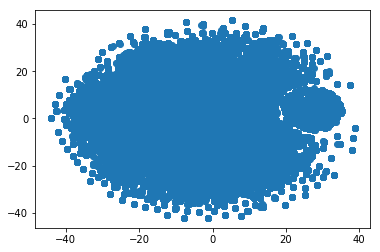

In [120]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(tweet2vec)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()

Now we will make a clustering representation

In [121]:
from sklearn.cluster import KMeans

In [122]:
k_means = KMeans(init='k-means++', n_clusters=5, n_init=10)
k_means.fit(X_tsne)
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)

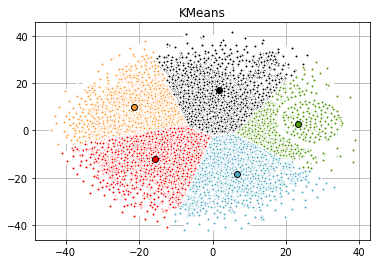

In [123]:
colors = ['#4EACC5', '#FF9C34', '#4E9A06','Red','Black']
plt.figure()
for k, col in zip(range(5), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    plt.plot(X_tsne[my_members, 0], X_tsne[my_members, 1], 'w',markerfacecolor=col, marker='.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,markeredgecolor='k', markersize=6)
plt.title('KMeans')    
plt.grid(True)
plt.show()

### Analyze clusters

In [124]:
cluster_index = [None]*len(tweet2vec)
for i in range(0,len(k_means_labels)):
    cluster_index[i] = k_means_labels[i]

In [125]:
c0 = []
c1 = []
c2 = []
c3 = []
c4 = []
for i in range(0,len(tweet2vec)):
    if cluster_index[i] == 1:
        c1.append(lines[i])
    if cluster_index[i] == 0:
        c0.append(lines[i])
    if cluster_index[i] == 2:
        c2.append(lines[i])
    if cluster_index[i] == 3:
        c3.append(lines[i])
    if cluster_index[i] == 4:
        c4.append(lines[i])

In [126]:
def topwords(cluster,top):
    terms = []
    for i in cluster:
        terms.append(getTerms(i))
    terms = list(itertools.chain.from_iterable(terms))
    
    terms_freq = Counter(terms)
    
    terms_freq = {k: terms_freq[k] for k in terms_freq if k!=None} 
    
    return terms_freq

In [133]:
c0_topwords = topwords(c0,5)
h = list(c0_topwords.keys())
c = list(c0_topwords.values())
df_c0 = {'hashtag':h,'count':c}
df_c0 = pd.DataFrame(df_c0)
df_c0.set_index("hashtag", inplace=True)
df_c0.sort_values("count", inplace=True, ascending=False)

c1_topwords = topwords(c1,5)
h = list(c1_topwords.keys())
c = list(c1_topwords.values())
df_c1 = {'hashtag':h,'count':c}
df_c1 = pd.DataFrame(df_c1)
df_c1.set_index("hashtag", inplace=True)
df_c1.sort_values("count", inplace=True, ascending=False)

c2_topwords = topwords(c2,5)
h = list(c2_topwords.keys())
c = list(c2_topwords.values())
df_c2 = {'hashtag':h,'count':c}
df_c2 = pd.DataFrame(df_c2)
df_c2.set_index("hashtag", inplace=True)
df_c2.sort_values("count", inplace=True, ascending=False)

c3_topwords = topwords(c3,5)
h = list(c3_topwords.keys())
c = list(c3_topwords.values())
df_c3 = {'hashtag':h,'count':c}
df_c3 = pd.DataFrame(df_c3)
df_c3.set_index("hashtag", inplace=True)
df_c3.sort_values("count", inplace=True, ascending=False)

c4_topwords = topwords(c4,5)
h = list(c4_topwords.keys())
c = list(c4_topwords.values())
df_c4 = {'hashtag':h,'count':c}
df_c4 = pd.DataFrame(df_c4)
df_c4.set_index("hashtag", inplace=True)
df_c4.sort_values("count", inplace=True, ascending=False)

In [134]:
df_c0[:5]

,count
hashtag,
vaccin,6089
covid19,4871
covid,4499
amp,2844
health,2684


In [135]:
df_c1[:5]

,count
hashtag,
covid,5799
vaccin,4728
get,3025
lockdown,2528
peopl,2271


In [136]:
df_c2[:5]

,count
hashtag,
covid19,4246
covid,3135
vaccin,3105
case,2814
death,2771


In [137]:
df_c3[:5]

,count
hashtag,
covid,6374
vaccin,6136
peopl,4069
get,3469
covid19,3200


In [138]:
df_c4[:5]

,count
hashtag,
lockdown,10763
covid,4452
vaccin,3888
covid19,3471
day,2370


In [139]:
 import pickle

In [140]:
with open("cluster_index.txt", "wb") as fp:   #Pickling
    pickle.dump(cluster_index, fp)